# SVM  para clasificación de asteroides



**Objetivo:** Clasificación de asteroides detectados por la NASA como peligrosos (Hazardous) y no peligrosos (Not Hazardous)

**Información del dataset**

NeoWs (Near Earth Object Web Service) is a RESTful web service for near earth Asteroid information. With NeoWs a user can: search for Asteroids based on their closest approach date to Earth, lookup a specific Asteroid with its NASA JPL small body id, as well as browse the overall data-set.


https://www.kaggle.com/shrutimehta/nasa-asteroids-classification



**Número de instancias:** 4687

# 1. Acceso a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Importando librerías

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import itertools
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# 3. Lectura del archivo de rasgos del dataset de fracturas

In [3]:
path = r"/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.7 Máquinas de soporte vectorial"
file = 'nasa.csv'

In [4]:
nasadf = pd.read_csv(os.path.join(path,file))
nasadf.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


# 4. Exploración de los datos y preparación

In [5]:
nasadf.shape

(4687, 40)

**Valores que toma la variable dependiente**

In [6]:
clases = nasadf.iloc[:,-1].unique()
n_clases = len(clases)
print(clases)

[ True False]


**Nombres de las columnas del dataframe**

In [7]:
nasadf.columns

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')

**Información sobre los tipos de dato en cada columna**

In [8]:
nasadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

**Eliminando las columnas 'Neo Reference ID', 'Name' y los que sean del tipo object**

In [9]:
nasadf = nasadf.drop(['Neo Reference ID', 'Name',
                      'Close Approach Date','Orbiting Body',
                      'Orbit Determination Date','Equinox'],axis=1)

In [10]:
nasadf

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,6.275369e+07,3.899334e+07,17,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.300,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,5.729815e+07,3.560342e+07,21,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.300,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7.622912e+06,4.736658e+06,22,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.400,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,4.268362e+07,2.652237e+07,7,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,6.101082e+07,3.791037e+07,25,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,23.900,0.044112,0.098637,44.111820,98.637028,0.027410,0.061290,144.723824,323.612307,1473318000000,22.154265,79755.354273,49556.875548,0.041361,16.089413,6.187511e+06,3.844741e+06,4,8,0.019777,5.156,2457637.5,0.361512,1.161429,39.880491,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436,False
4683,28.200,0.006089,0.013616,6.089126,13.615700,0.003784,0.008460,19.977449,44.670934,1473318000000,3.225150,11610.539577,7214.337772,0.006469,2.516399,9.677324e+05,6.013211e+05,2,6,0.006451,5.742,2458000.5,0.073200,1.075134,5.360249,345.225230,407.185767,0.996434,42.111064,1.153835,2.458088e+06,282.978786,0.884117,False
4684,22.700,0.076658,0.171412,76.657557,171.411509,0.047633,0.106510,251.501180,562.373736,1473318000000,7.191642,25889.910626,16086.983633,0.061009,23.732393,9.126775e+06,5.671115e+06,17,6,0.059973,4.410,2458000.5,0.368055,1.528234,4.405467,37.026468,690.054279,0.965760,274.692712,2.090708,2.458300e+06,203.501147,0.521698,False
4685,21.800,0.116026,0.259442,116.025908,259.441818,0.072095,0.161210,380.662441,851.187094,1473318000000,11.352090,40867.522309,25393.489071,0.260760,101.435493,3.900908e+07,2.423912e+07,6,5,0.177510,4.477,2458000.5,0.202565,1.486600,21.080244,163.802910,662.048343,1.185467,180.346090,1.787733,2.458288e+06,203.524965,0.543767,False


# 5. Escalamiento y codificación

In [11]:
scaler = StandardScaler()
nasadf.loc[:, nasadf.columns != 'Hazardous'] = scaler.fit_transform(nasadf.loc[:, nasadf.columns != 'Hazardous'])

# Distribución de clases

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


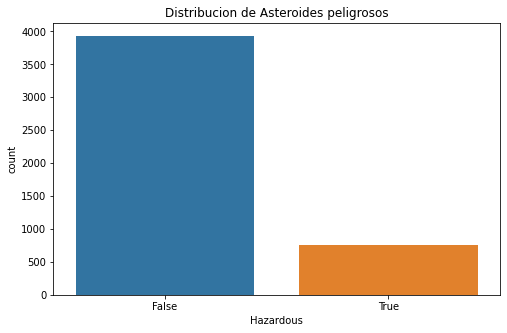

In [18]:
f,ax=plt.subplots(figsize=(8,5))
sns.countplot(nasadf['Hazardous'], ax=ax)
ax.set_title('Distribucion de Asteroides peligrosos')
plt.show()

# Undersampling

In [51]:
X = nasadf.drop(['Hazardous'],axis=1)
y = nasadf['Hazardous'].values

In [52]:
# estrategia de submuestreo
sampling = RandomOverSampler(sampling_strategy='minority')
# ajustar y aplicar el submuestreo
X, y = sampling.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


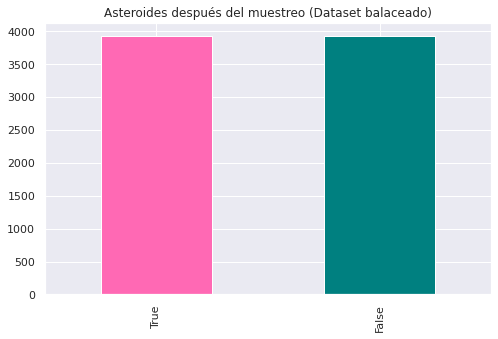

In [54]:
fig = plt.figure(figsize = (8,5))
p = pd.Series(y).value_counts(normalize = False).plot(kind='bar', color= ['hotpink','teal'])
p.set_xticklabels(nasadf['Hazardous'].unique())
plt.title('Asteroides después del muestreo (Dataset balaceado)')
plt.show()

# 6. Validación

In [55]:
seed = 40

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

# 7. Máquina de soporte vectorial para clasificación

**Creación del objeto svm a partir de la clase SVC**

In [57]:
svm =  SVC(random_state=seed)

**Entrenamiento**

In [58]:
svm = svm.fit(X_train,y_train)

**Score de accuracy de entrenamiento**

In [59]:
svm.score(X_train, y_train)

0.966142107773009

**Clasificación de datos de prueba**

In [60]:
y_pred = svm.predict(X_test)

**Accuracy de datos de prueba**

In [61]:
score = metrics.accuracy_score(y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.961220597584234


In [64]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.savefig(title+'.png')
    plt.grid(False)
    plt.show()

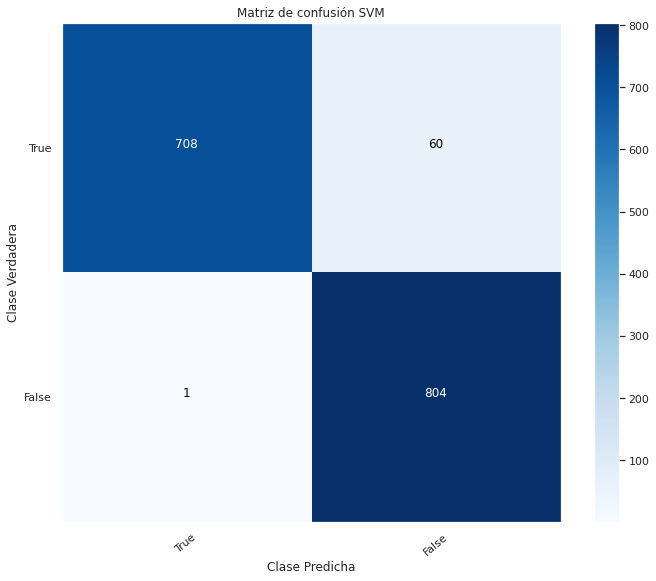

In [65]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=range(n_clases))
tit = 'Matriz de confusión SVM'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

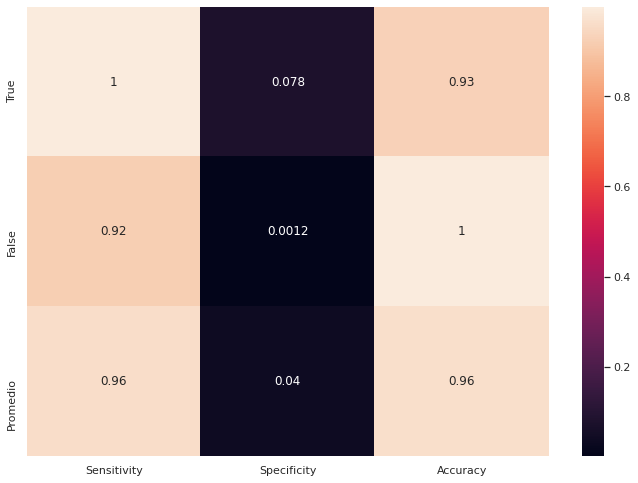

In [66]:
sensitivity = []
specificity = []
acc=[]
for i,name in enumerate(nasadf.Hazardous.unique()):
  TP = np.sum((y_test==name) & (y_pred==name))
  TN = np.sum((y_test!=name) & (y_pred!=name))
  FP = np.sum((y_test!=name) & (y_pred==name))
  FN = np.sum((y_test==name) & (y_pred!=name))
  sensitivity.append(TP/(TP+FN))
  specificity.append(FP/(TN+FP))
  acc.append(TP/(TP+FP))
sensitivity.append(sum([x*y for x,y in zip(sensitivity,[1/2]*2)]))
specificity.append(sum([x*y for x,y in zip(specificity,[1/2]*2)]))
acc.append(sum([x*y for x,y in zip(acc,[1/2]*2)]))
d = {'Sensitivity':sensitivity, 'Specificity':specificity, 'Accuracy':acc}
ind = list(clases)+['Promedio']
df = pd.DataFrame(d, index=ind)
index = df.index
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)